# Logistic Regression 

In this notebook, we ask you to use thee Logistic Regression to predict probability distributions for the travel modes. 

Make use of the processed datasets from the previous notebook (`train_validate.csv` and `test.csv`), remembering to remove the ID/context columns (see previous notebook). 

Tasks:

1. Import and use the `LogisticRegressionClassifier` to predict *probability distributions* over the modes for the dataset (you will need to use a different `predict` function, check the documentation!)
    * Use the `saga` solver, which works with both L1 and L2 regularization.
    * Use the `multinomial` approach for the `multi_class` data
    * Remember to split the `train_validate` data into a training and validation set
    * You may need to set the tolerance or max iterations so the model fits in reasonable time
    
    
2. Implement a function called `cross_entropy_loss` which takes the class labels and probability distributions and calculates the cross-entropy loss. 
    * Use your function to calculate the loss for the logistic regression model
    * Compare your results with the `log_loss` function in scikit-learn
    

3. Experiment with scaling the data (using `StandardScaler`). Does scaling improve your results?
    * Remember, fit the scaler on the training data, and then transform both train and validation/test data!
    
    
4. Experiment with the regularisation (L1/L2) and $C$ hyperparameters to minimize cross-entropy loss
    * Make sure you use only the `train_validate` data to test model hyperparameters
    
    
5. Evaluate your finished model on the data in `test.csv`
    * Remember to retrain the model using the full `train_validate` data
    
    
6. Submit the notebook on Moodle by Sunday 8th March at 11:59pm

## Question 1: Logistic Regression

First, we import the libraries and the files that were created in the first notebook.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
df_train_validate = pd.read_csv('data/train_validate.csv', index_col='trip_id')

We can now create the features and target for the `df_train_validate`.

In [3]:
target = ['travel_mode']
id_context = ['trip_id', 
              'household_id', 
              'person_n', 
              'trip_n',
              'survey_year',
              'travel_year'
             ]
features = [c for c in df_train_validate.columns 
            if c not in (target + id_context)]

y = df_train_validate[target]
X = df_train_validate[features]

We split the `df_train_validate` into two sets, one for the training and one for the validation.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Warning**: If we use the targets `y` as is, they will be of type `pandas.core.frame.DataFrame`. It is thus recommended to get the values to get `np.array`.

In [5]:
y_train = y_train.travel_mode.values
y_validate = y_validate.travel_mode.values

We can now import the Logistic Regression from `sklearn`, train it on the training set, and "test" it on the validation set.

In [6]:
logreg = LogisticRegression(solver='saga', 
                            multi_class='multinomial', 
                            max_iter = 100)

In [7]:
%%time 
logreg.fit(X_train, y_train)

CPU times: user 4.87 s, sys: 34 ms, total: 4.91 s
Wall time: 4.98 s


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

*This part is going beyond the scope of this question*

We can now use the accuracy or anything else you know to have an idea on the performance of the model. It is interesting to see what is happening here before improving our model.

In [8]:
y_pred = logreg.predict(X_validate)

In [9]:
acc = metrics.accuracy_score(y_pred, y_validate)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 51.95%


The accuracy is not good at all. The best way to understand what is going on is to use the precision, recall, and the confusion matrix as seen in notebook 1.

In [10]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

classes = np.array(['walk', 'cycle', 'pt', 'drive'])

print('Confusion matrix, without normalization:')
display(confusion_matrix(y_validate, y_pred))

fig, ax = plt.subplots()
plot_confusion_matrix(logreg, X_validate, y_validate, display_labels=classes,values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Confusion matrix, without normalization:


array([[ 219,    0,    6, 1662],
       [   5,    0,   43,  251],
       [  11,    0, 1444, 2405],
       [  33,    0,  847, 4028]])

Here, we can clearly see the issue. The Logistic Regression tends to over predict the `drive` mode instead of the others. `cycle` is under represented in the dataset which lead to the algorithm forgetting that it exists.

# Question 2: Cross Entropy Loss

In [11]:
def cross_entropy_loss(proba, y_true):
    """
    Compute the cross entropy loss
    
    Input:
        proba: Matrix of probabilities. Size is NxC where N is the number of entries in the dataset and C is the number of classes.
        y_true: Array with the correct labels. Size is N where N is the number of entries in the dataset.
        
    Output:
        Returns the value of the cross entropy loss
    
    """
    
    # Let's make some test to make sure we have the right variables. 
    # It's not mandatory, but good practices!
    
    if proba.shape[0] != len(y_true):
        raise ValueError("The matrix and the array do not have the same size")
        
    y_true = np.array(y_true)
    proba = np.array(proba) # Small way to make sure it has the right type
    
    # Our goal here is to first retrieve the probabilities corresponding to the true choices
    N = len(y_true)
    chosen_proba = proba[range(N), y_true]
    
    # We can now sum the log of the probabilities and divide by N
    cel = -np.sum(np.log(chosen_proba))/N
    
    return cel

We get the probabilities and compute the Cross Entropy Loss.

In [12]:
proba_validate = logreg.predict_proba(X_validate)

In [13]:
cel = cross_entropy_loss(proba_validate, y_validate)
print("Cross Entropy Loss = {:.4f}".format(cel))

Cross Entropy Loss = 0.9954


We can no test our function against the function in `sklearn`.

In [14]:
logl = log_loss(y_validate, proba_validate)
print("Log Loss = {:.4f}".format(logl))

Log Loss = 0.9954


It seems that the values are similar, but just to make sure, it's good to test the difference between the two. =)

You can either use the operator `==` or check the difference. However, sometimes with doubles, you can have extremely small difference between the two numbers. So, it's possible that the operator `==` returns False.

In [15]:
logl == cel

True

In [16]:
diff = np.abs(logl-cel)
print(diff)

0.0


# Question 3: Scaling

When you do something to your data, being either feature engineering, or scaling, or anything else, you should always fit on the training data and then apply it to your validation/testing set.

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

We can now test if the Logistic Regression is better now.

In [18]:
%%time 
logreg.fit(X_train_scaled, y_train)

CPU times: user 4.83 s, sys: 19.2 ms, total: 4.85 s
Wall time: 4.86 s


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
proba_validate = logreg.predict_proba(X_validate_scaled)

In [20]:
logl_scaled = log_loss(y_validate, proba_validate)
print("Log Loss = {:.4f}".format(logl_scaled))

Log Loss = 0.6714


We see here that we go from 0.9954 to 0.6714 which corresponds to roughly a 30% improvement. Let's have a look at the confusion matrix.

In [22]:
y_pred_scaled = logreg.predict(X_validate_scaled)

In [23]:
print('Confusion matrix, without normalization:')
display(confusion_matrix(y_validate, y_pred_scaled))

fig, ax = plt.subplots()
plot_confusion_matrix(logreg, X_validate_scaled, y_validate, display_labels=classes,values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Confusion matrix, without normalization:


array([[1301,    0,  182,  404],
       [  70,    0,  113,  116],
       [ 259,    1, 2729,  871],
       [ 304,    0,  482, 4122]])

This time, we see that the values on the diagonal are predicted better, except for the `cycle`. This explains the huge improvement. Let's try to improve it even more!

# Question 4: Hyperparameter exploration

We can play with all the parameters for the Logistic Regression. However, we will concentrate on the parameters C and the penalty. Since the values for the penalty are discrete, we will store everything in a dictionary. You can do it as you want.

In [24]:
res = {}
penalty = ['l1', 'l2']


strength = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100]

# We go through all penalties
for p in penalty:
    # Prepare the dict
    res[p] = []
    
    # Go through the values for the strength
    for c in strength:
        
        print("Check LogReg for penalty {}, strength {}".format(p, c))
        
        # Prepare the logreg
        logreg = LogisticRegression(solver='saga', 
                            multi_class='multinomial', 
                            max_iter = 100,
                            penalty = p,
                            C = c)
        
        # Fit it
        logreg.fit(X_train_scaled, y_train)
        
        # Get the probabilities
        proba_validate = logreg.predict_proba(X_validate_scaled)
        
        # Get the cross entropy loss
        logl = log_loss(y_validate, proba_validate)
        
        # Add it to our results
        res[p].append(logl)

Check LogReg for penalty l1, strength 0.01


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 0.02


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 0.05


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 0.1


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 0.2


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 0.5


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 1


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 2


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 5


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 10


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 20


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 50


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l1, strength 100


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 0.01
Check LogReg for penalty l2, strength 0.02
Check LogReg for penalty l2, strength 0.05
Check LogReg for penalty l2, strength 0.1


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 0.2


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 0.5


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 1


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 2


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 5


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 10


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 20


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 50


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check LogReg for penalty l2, strength 100


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The next step is to find the best set of parameters based on our results.

In [25]:
if np.min(res['l1']) < np.min(res['l2']):
    best_pen = 'l1'
    best_c = strength[np.argmin(res['l1'])]
else:
    best_pen = 'l2'
    best_c = strength[np.argmin(res['l2'])]       
    
print("Best set of parameters: penalty: {}; C: {}".format(best_pen, best_c))

Best set of parameters: penalty: l1; C: 100


It can also be interesting to have a look at the different values across the parameters. There are many ways to do it. We propose here one that works for this particular set of parameters. Feel free to be creative. =)

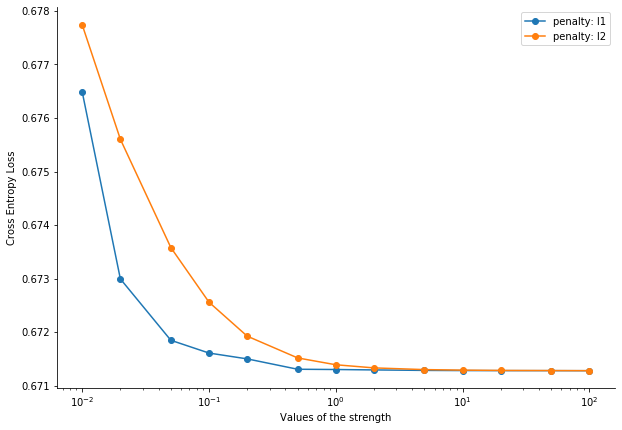

In [27]:
plt.figure(figsize=(10, 7), frameon=False)

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.semilogx(strength, res['l1'], 'o-', label='penalty: l1')
plt.semilogx(strength, res['l2'], 'o-', label='penalty: l2')

plt.xlabel('Values of the strength')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

We can see from the graph that the penalty l1 is better than the penalty l2. In addition, we can see that if the strength is greater than 1, there isn't any significant changes. Thus, a value of 1 or 2 (as suggested by the best set of parameters) is good.

# Question 5: Test set

Now that we know the best parameters, we have to retrain the model on the whole dataset. But first, let's load the test set.

In [28]:
df_test = pd.read_csv('data/test.csv', index_col='trip_id')
y_test = df_test[target]
X_test = df_test[features]

Let's scale the test set

In [29]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

We can now fit the Logistic Regression

In [30]:
%%time
logreg = LogisticRegression(solver='saga', 
                    multi_class='multinomial', 
                    max_iter = 100,
                    penalty = 'l1',
                    C = 2)

# Fit it
logreg.fit(X_scaled, y)

# Get the probabilities
proba = logreg.predict_proba(X_test_scaled)

# Get the predicted labels
y_pred = logreg.predict(X_test_scaled)

//miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 7.62 s, sys: 30.4 ms, total: 7.65 s
Wall time: 7.69 s


//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


We can compute the Cross Entropy Loss and the Confusion matrix.

In [31]:
logl = log_loss(y_test, proba)

print("Cross Entropy Loss: {:.4f}".format(logl))

Cross Entropy Loss: 0.6946


In [32]:
acc = metrics.accuracy_score(y_pred, y_test)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 73.53%


Confusion matrix, without normalization:


array([[3027,    0,  537, 1120],
       [ 182,    1,  399,  279],
       [ 650,    3, 6876, 1972],
       [ 725,    1, 1099, 9449]])

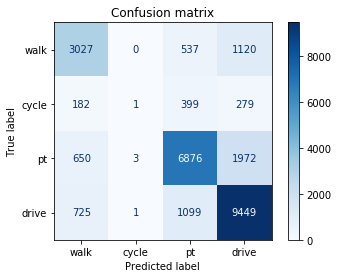

In [33]:
print('Confusion matrix, without normalization:')
display(confusion_matrix(y_test, y_pred))

fig, ax = plt.subplots()
plot_confusion_matrix(logreg, X_test_scaled, y_test, display_labels=classes,values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

We can see the same kind of result as before. Indeed, we have correct results for `drive`, `pt`, and `walk`. However, due to the under representation of `cycle`, the model is really bad at predicting correctly for this travel mode.